# Sentiment Analysis: Large Movie Review Dataset

This project is a NLP project that uses a dataset for __binary sentiment classification__.
We are going to use the data from [AI Stanford Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

A basic sentiment analysis problem consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a movie speaks positively or negatively.

### These are the objectives of the project:

* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* BoW and TF-IDF are classic ways to vectorize text, but currently we have some more complex ways with better performance, for this we are going to train our own word embedding and use it as a vectorization source for our data.
* Train a sentiment analysis model that allows us to detect positive and negative opinions in movie reviews.

In [1]:
import os
import nltk
import pickle
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize.toktok import ToktokTokenizer
from tqdm import tqdm

import evaluation
import text_normalizer

[nltk_data] Downloading package stopwords to /home/app/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
## 1. Get the data

In [2]:
if os.path.exists('data/data_lists/X_train.pickle'):
    with open('data/data_lists/X_train.pickle', 'rb') as f:
        X_train = pickle.load(f)
    with open('data/data_lists/y_train.pickle', 'rb') as f:
        y_train = pickle.load(f)
else:
    X_train = []
    y_train = []

    for (root, _, files) in os.walk(os.path.join('data/', 'train', 'neg')):
        for file in files:
            with open(os.path.join('data/', 'train', 'neg', file)) as f:
                lines = f.readlines()
            X_train.append(lines[0])
            y_train.append(0)

    for (root, _, files) in os.walk(os.path.join('data/', 'train', 'pos')):
        for file in files:
            with open(os.path.join('data/', 'train', 'pos', file)) as f:
                lines = f.readlines()
            X_train.append(lines[0])
            y_train.append(1)

    with open('data/data_lists/X_train.pickle', 'wb') as f:
        pickle.dump(X_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('data/data_lists/y_train.pickle', 'wb') as f:
        pickle.dump(y_train, f, protocol=pickle.HIGHEST_PROTOCOL)


if os.path.exists('data/data_lists/X_test.pickle'):
    with open('data/data_lists/X_test.pickle', 'rb') as f:
        X_test = pickle.load(f)
    with open('data/data_lists/y_test.pickle', 'rb') as f:
        y_test = pickle.load(f)
else:
    X_test  = []
    y_test  = []

    for (root, _, files) in os.walk(os.path.join('data/', 'test', 'neg')):
        for file in files:
            with open(os.path.join('data/', 'test', 'neg', file)) as f:
                lines = f.readlines()
            X_test.append(lines[0])
            y_test.append(0)

    for (root, _, files) in os.walk(os.path.join('data/', 'test', 'pos')):
        for file in files:
            with open(os.path.join('data/', 'test', 'pos', file)) as f:
                lines = f.readlines()
            X_test.append(lines[0])
            y_test.append(1)

    with open('data/data_lists/X_test.pickle', 'wb') as f:
        pickle.dump(X_test, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('data/data_lists/y_test.pickle', 'wb') as f:
        pickle.dump(y_test, f, protocol=pickle.HIGHEST_PROTOCOL)


In [3]:
def check_data(X_train, y_train, X_test, y_test):
    if len(X_train) == len(y_train) == len(X_test) == len(y_test) == 25000:
        print('Reading Data Success!')
    else:
        raise ValueError('Dimensions do not match!')

check_data(X_train, y_train, X_test, y_test)

Reading Data Success!


---
## 2. Normalize the data

In [4]:
if os.path.exists('data/normalized_data_lists/normalized_train.pickle'):
    with open('data/normalized_data_lists/normalized_train.pickle', 'rb') as f:
        c_X_train = pickle.load(f)
else:
    c_X_train = text_normalizer.normalize_corpus(X_train, text_stemming = True)
    with open('data/normalized_data_lists/normalized_train.pickle', 'wb') as f:
        pickle.dump(c_X_train, f, protocol=pickle.HIGHEST_PROTOCOL)

if os.path.exists('data/normalized_data_lists/normalized_test.pickle'):
    with open('data/normalized_data_lists/normalized_test.pickle', 'rb') as f:
        c_X_test = pickle.load(f)
else:
    c_X_test = text_normalizer.normalize_corpus(X_test, text_stemming = True)
    with open('data/normalized_data_lists/normalized_test.pickle', 'wb') as f:
        pickle.dump(c_X_test, f, protocol=pickle.HIGHEST_PROTOCOL)


We are going to check that the pre-processing does what we need it to do, for this we are going to test the functions with predefined inputs and we are going to see if the outputs match what we are looking for.

In [5]:
import nltk

# Inputs
doc_html = """
<br /><br />But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
doc_accented = "Héllo, thís is an accented sénténce."
doc_contractions = "I can't, because it doesn't work."
doc_lemma = "The striped bats are hanging on their feet for best"
doc_stem = """
Where did he learn to dance like that?
His eyes were dancing with humor.
She shook her head and danced away.
"""
doc_specials = "hello? there A-Z-R_T(,**), world, welcome to python. this **should? the next line#followed- by@ an#other %million^ %%like $this."
doc_digits = "abc123def456ghi789zero0 hello my friend number 10"
doc_stop = "He is a very good person"
doc_new_lines = """we
use
a
lot
of
lines"""
doc_spaces = "Hello           my      dear          friend"

# Outputs
good_html = """
But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
good_accented = "Hello, this is an accented sentence."
good_contractions = "I cannot, because it does not work."
good_lemma = "the stripe bat be hang on their foot for good"
good_stem = "where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away ."
good_specials = "hello there AZRT world welcome to python this should the next linefollowed by another million like this"
good_digits = "abcdefghizero hello my friend number "
good_stop = "good person"
good_new_lines = "we use a lot of lines"
good_spaces = "Hello my dear friend"

# Example of stop words
stop_words = nltk.corpus.stopwords.words('english')


def check_normalization():
    if good_html == text_normalizer.remove_html_tags(doc_html):
        print('[1/10] Remove HTML Success!')
    else:
        raise ValueError('[1/10] Remove HTML Fail!')

    if good_accented == text_normalizer.remove_accented_chars(doc_accented):
        print('[2/10] Remove Accented Success!')
    else:
        raise ValueError('[2/10] Remove Accented Fail!')
        
    if good_contractions == text_normalizer.expand_contractions(doc_contractions):
        print('[3/10] Expand Contractions Success!')
    else:
        raise ValueError('[3/10] Expand Contractions Fail!')
        
    if good_lemma == text_normalizer.lemmatize_text(doc_lemma):
        print('[4/10] Lemmatization Success!')
    else:
        raise ValueError('[4/10] Lemmatization Fail!')

    if good_stem == text_normalizer.stem_text(doc_stem):
        print('[5/10] Stemming Success!')
    else:
        raise ValueError('[5/10] Stemming Fail!')

    if good_specials == text_normalizer.remove_special_chars(doc_specials):
        print('[6/10] Remove Specials Success!')
    else:
        raise ValueError('[6/8] Remove Specials Fail!')

    if good_digits == text_normalizer.remove_special_chars(doc_digits, remove_digits = True):
        print('[7/10] Remove Digits Success!')
    else:
        raise ValueError('[7/10] Remove Digits Fail!')

    if good_stop == text_normalizer.remove_stopwords(doc_stop, stopwords=stop_words):
        print('[8/10] Remove Stopwords Success!')
    else:
        raise ValueError('[8/10] Remove Stopwords Fail!')

    if good_new_lines == text_normalizer.remove_extra_new_lines(doc_new_lines):
        print('[9/10] Remove New Lines Success!')
    else:
        raise ValueError('[9/10] Remove New Lines Fail!')

    if good_spaces == text_normalizer.remove_extra_whitespace(doc_spaces):
        print('[10/10] Remove Extra Whitespaces Success!')
    else:
        raise ValueError('[10/10] Remove Extra Whitespaces Fail!')

check_normalization()

[1/10] Remove HTML Success!
[2/10] Remove Accented Success!
[3/10] Expand Contractions Success!
[4/10] Lemmatization Success!
[5/10] Stemming Success!
[6/10] Remove Specials Success!
[7/10] Remove Digits Success!
[8/10] Remove Stopwords Success!
[9/10] Remove New Lines Success!
[10/10] Remove Extra Whitespaces Success!


---
## 3. Feature Engineering

We already have the preprocessed data, now we are going to vectorize it. Two possibilities to vectorize are BoW or TF-IDF.

In [6]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")

train_values = tfidf_vectorizer.fit_transform(c_X_train)
test_values  = tfidf_vectorizer.transform(c_X_test)

## 4. Modeling and Performance Evaluation

In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 1)
model.fit(train_values, y_train)
y_pred = model.predict(test_values)

Let's check that the `get_performance` function returns the metrics correctly. For that we are going to simulate input/output data of a model.

In [8]:
def check_basic_metrics():
    accuracy, precision, recall, f1_score = evaluation.get_performance(
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
    )
    
    if (accuracy, precision, recall, f1_score) == (0.6, 0.6, 0.6, 0.6):
        print('Success!')
    else:
        raise ValueError('You must check your get_performance function!')
        
check_basic_metrics()

Model Performance metrics:
------------------------------
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1 Score: 0.6

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10


Prediction Confusion Matrix:
------------------------------
   0  1
0  3  2
1  2  3
Success!


Model Performance metrics:
------------------------------
Accuracy: 0.87388
Precision: 0.8718275121330257
Recall: 0.87664
F1 Score: 0.8742271331126092

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10889   1611
1   1542  10958


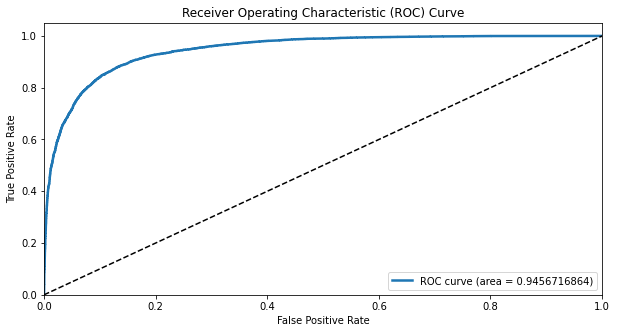

ROC AUC performance: 0.9456716864


In [9]:
evaluation.get_performance(y_pred, y_test)
roc_auc = evaluation.plot_roc(model, y_test, test_values)
print("ROC AUC performance:", roc_auc)

Let's see if your model at least exceeds an ROC-AUC of 0.92 wich is our target in the project.

In [10]:
def check_roc(roc_auc):
    if roc_auc > 0.92:
        print('Success!')
    else:
        raise ValueError('Your model is not good enough!')
        
check_roc(roc_auc)

Success!


---
## 5. Feature Engineering with Custom Word Embedding

In [11]:
tokenizer = ToktokTokenizer()

X_train_tok = []
X_test_tok  = []

for review in c_X_train:
    X_train_tok.append(tokenizer.tokenize(review))
for review in c_X_test:
    X_test_tok.append(tokenizer.tokenize(review))

model_w2v = Word2Vec(sentences=X_train_tok, vector_size=100, min_count=1, workers=4, epochs=50)

### Generate averaged word vector features

Embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, you must average the vectors of all the words that are part of the same review.

In [12]:
def vectorizer(corpus, model, num_features=100):

    corpus_vectors = []
    
    for review in corpus:
        add = np.zeros(100)
        count_word = 0
        for word in review:
            try:
                add = add + model.wv[word]
                count_word = count_word + 1
            except:
                pass

        corpus_vectors.append(add / count_word)

    return corpus_vectors

In [13]:
corpus_vect_train = vectorizer(X_train_tok, model_w2v)
corpus_vect_test  = vectorizer(X_test_tok, model_w2v)

Let's do a simple check of the embedding that you just trained.

In [14]:
def check_embedding(model):
    vector = model.wv['computer']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2v)

Success! Your embedding tells me that "women" and "man" are similar with a score of 0.6231294274330139


In [15]:
def check_vectorizer(model):
    vector1 = model.wv['personal']
    vector2 = model.wv['computer']
    avg = vectorizer([['personal', 'computer']], model)[0]
    
    if np.allclose((vector1 + vector2) / 2, avg):
        print('Success!')
    else:
        raise ValueError('You should check your vectorizer!')
        
check_vectorizer(model_w2v)

Success!


### Modeling

In [16]:
model_vect = LogisticRegression(random_state = 1)
model_vect.fit(corpus_vect_train, y_train)
y_pred_vect = model_vect.predict(corpus_vect_test)

Model Performance metrics:
------------------------------
Accuracy: 0.84432
Precision: 0.8440997761432683
Recall: 0.84464
F1 Score: 0.8443698016634676

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10550   1950
1   1942  10558


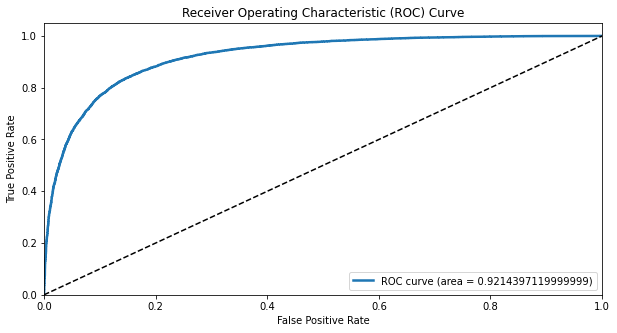

ROC AUC performance: 0.9214397119999999


In [17]:
evaluation.get_performance(y_pred_vect, y_test)
roc_auc_vect = evaluation.plot_roc(model_vect, y_test, corpus_vect_test)
print("ROC AUC performance:", roc_auc_vect)

In [18]:
check_roc(roc_auc_vect)

Success!
